## Inference (generate reps for) all GFP sequences we'll need in order to make the PCA plots for Fig 4.

This notebook generates the representations and stores them in pickles. It is compute heavy. Downstream notebooks call on these precomputed reps, thus it's not necessary to run this notebook in order to run downstream ones.

In [1]:
import os
import sys
import warnings
import multiprocessing as mp
import random
import pickle
import glob
import time
from collections import OrderedDict

from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.decomposition import PCA
from scipy.interpolate import UnivariateSpline

sys.path.append('../common')
import data_io_utils
import paths
import utils
import constants

sys.path.append('../A003_policy_optimization/')
import A003_common
import models

sys.path.append('../A008_analyze_chip_1/')
import A008_common

import A011_common

%reload_ext autoreload
%autoreload 2

## Inference a collection of GFP sequences

We'll inference all possible interesting GFP sequences and come up with a dictionary that maps sequence to representation.

### Evotuning seqs

In [2]:
seq_file = 'GFP_evotuning_seqs_wide_jackhmmer_3_train.txt'
with open(seq_file) as f:
    seqs = f.read().splitlines()
    
print(len(seqs))

25781


### Sarkisyan data

In [3]:
seq_files = [paths.SARKISYAN_SPLIT_0_FILE, paths.SARKISYAN_SPLIT_1_FILE, paths.SARKISYAN_SPLIT_2_FILE]
for sf in seq_files:
    data_io_utils.sync_s3_path_to_local(sf, is_single_file=True)
    
df = pd.concat([pd.read_csv(sf) for sf in seq_files], axis=0)

seqs += list(df['seq'])

print(len(seqs))

77496


### A011f random sequences

In [6]:
seq_file = 'A011f_GFP_random_seqs.txt'
with open(seq_file) as f:
    rseqs = f.read().splitlines()
    
seqs += rseqs
print(len(seqs))

128005


## Some evolutionary trajectories

We want trajectories that have a lot of dynamic range. Start from the bottom and now they here.

In [7]:
traj_dir = os.path.join(data_io_utils.S3_DATA_ROOT, 'chip_1/simulated_annealing/GFP')

traj_file = os.path.join(traj_dir, 'GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e.p')
data_io_utils.sync_s3_path_to_local(traj_file, is_single_file=True)

with open(traj_file, 'rb') as f:
    traj_data = pickle.load(f)
    
# traj_data['sa_results']['seq_history'] is a list of lists. rows = iterations, columns = trajectories.

16


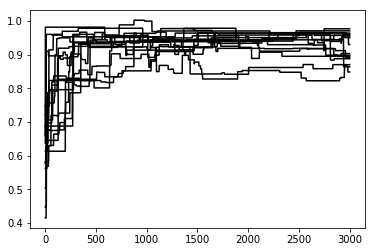

In [8]:
fit = np.array(traj_data['sa_results']['fitness_history'])
mask = np.logical_and(np.min(fit, axis=0) < 0.75, np.max(fit, axis=0) > 0.95)

print(np.sum(mask))

sidx = np.argwhere(mask).reshape(-1)

plt.plot(fit[:,mask], '-k')
plt.show()

In [9]:
trajectory_idx = sidx

seq_history = np.array(traj_data['sa_results']['seq_history'])
print(seq_history.shape)


traj_seqs = []
traj_dict = {}
for i in range(len(trajectory_idx)):
    traj_name = os.path.basename(traj_file).replace('.p', '_') + 'traj-' + str(trajectory_idx[i])
    
    seq2qfunc = OrderedDict()
    s = list(seq_history[:, trajectory_idx[i]])
    qfuncs = fit[:, trajectory_idx[i]]
    
    for j in range(len(s)):
        seq2qfunc[s[j]] = qfuncs[j]
    
    print(traj_name, len(seq2qfunc))
    
    traj_dict[traj_name] = seq2qfunc
    traj_seqs += s

(3001, 3500)
GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-1 15
GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-200 20
GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-313 23
GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-596 22
GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-716 26
GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-826 11
GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-938 6
GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-1508 19
GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-1562 13
GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-1974 20
GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-2323 14
GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-2388 24
GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-2646 23
GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-2855 33
GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-3143 35
GFP_SimAnneal-ET_Global_Init_1-0096-00-3ea5f6e_traj-3171 30


In [10]:
with open('A011a_GFP_example_trajectories.p', 'wb') as f:
    pickle.dump(file=f, obj=traj_dict)

In [11]:
seqs += traj_seqs
print(len(seqs))

176021


## Designed sequences

In [12]:
inf_brightness_data_file = os.path.join(data_io_utils.S3_DATA_ROOT, 'chip_1', 
                'A052b_Chip_1_inferred_brightness_v2.csv')
data_io_utils.sync_s3_path_to_local(inf_brightness_data_file, is_single_file=True)

df = pd.read_csv(inf_brightness_data_file)
q = df['id'].apply(lambda s: pd.Series(A008_common.split_seq_id_into_features(s)))
design_df = df.merge(q, left_index=True, right_index=True)

In [13]:
dseqs = list(design_df['seq'])
print(len(dseqs))

dseqs = [s for s in dseqs if isinstance(s, str)]

seqs += dseqs
print(len(seqs))

14306
190325


## Now we inference!

In [14]:
data_io_utils.sync_s3_path_to_local(paths.EVOTUNING_CKPT_DIR)

In [15]:
def seq2rep_dict(seqs, reps, log_likes):
    assert len(seqs) == reps.shape[0]
    
    d = {}
    for i,s in enumerate(seqs): 
        d[s] = (reps[i], log_likes[i]) 
        
    return d

In [16]:
weight_paths = [
    paths.GFP_ET_RANDOM_INIT_1_WEIGHT_PATH, 
    paths.GFP_ET_GLOBAL_INIT_1_WEIGHT_PATH, 
    paths.GFP_ET_GLOBAL_INIT_2_WEIGHT_PATH
]

output_paths = [
    os.path.join(data_io_utils.S3_DATA_ROOT, 'datasets/A011', 'GFP_seq2rep_random_init_v2.p'),
    os.path.join(data_io_utils.S3_DATA_ROOT, 'datasets/A011', 'GFP_seq2rep_et_global_init_1_v2.p'),
    os.path.join(data_io_utils.S3_DATA_ROOT, 'datasets/A011', 'GFP_seq2rep_et_global_init_2_v2.p')
]

In [17]:
for op in output_paths:
    data_io_utils.sync_s3_path_to_local(op, is_single_file=True)

In [18]:
for i in range(len(weight_paths)):
    print(weight_paths[i], output_paths[i])
    
    if os.path.exists(output_paths[i]) and True:
        print('seq2rep dictionary already exists')
        with open(output_paths[i], 'rb') as f:
            s2r = pickle.load(file=f)
    else:
        print('Starting fresh')
        s2r = {}
        
    remaining_seqs = list(set(seqs) - set(s2r.keys()))
        
    print(len(remaining_seqs), 'to inference')
    
    if len(remaining_seqs) > 0:
        reps, logits, log_likes = A011_common.inference_seqs(
                remaining_seqs, model_weight_path=weight_paths[i], return_loglikes=True)
        
        d = seq2rep_dict(remaining_seqs, reps, log_likes)
        s2r.update(d)

        os.makedirs(os.path.dirname(output_paths[i]), exist_ok=True)
        with open(output_paths[i], 'wb') as f:
            pickle.dump(file=f, obj=s2r)
    
        # Post publication note: Disabling sync to our private bucket, which will reject the request anyway.
        #data_io_utils.sync_local_path_to_s3(output_paths[i], is_single_file=True)

/notebooks/analysis/common/../../data/s3/evotuning_checkpoints/gfp/unirep_random_init_1 /notebooks/analysis/common/../../data/s3/datasets/A011/GFP_seq2rep_random_init_v2.p
seq2rep dictionary already exists
13624 to inference


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Initializing variables

0 500
Time taken to do batch: 68.72888255119324

500 1000
Time taken to do batch: 1.4670169353485107

1000 1500
Time taken to do batch: 1.4619419574737549

1500 2000
Time taken to do batch: 1.4611129760742188

2000 2500
Time taken to do batch: 1.4650640487670898

2500 3000
Time taken to do batch: 1.459200382232666

3000 3500
Time taken to do batch: 1.4576711654663086

3500 4000
Time taken to do batch: 1.4759325981140137

4000 4500
Time taken to do batch: 1.457320213317871

4500 5000
Time taken to do batch: 1.4640276432037354

5000 5500
Time taken to do batch: 1.4629931449890137

5500 6000
Time taken to do batch: 1.4613254070281982

6000 6500
Time taken to do batch: 1.4773294925689697

6500 7000
Time taken to do batch: 1.4744222164154053

7000 7500
Time taken to do batch: 1.4585864543914795

7500 8000
Time taken to do batch: 1.4752635955810547

8000 8500
Time taken to do batch: 1.4599318504333496

8500 9000
Time taken to do batch: 1.4632956981658936

9000 9500
Ti